In [1]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.preprocessing import normalize
from nltk.tokenize import sent_tokenize
import numpy as np
import faiss
from numpy import dot
import torch

# 1. Set device efficiently
device = 0 if torch.cuda.is_available() else -1

# 2. Targeted keyword filtering — small but diverse
keywords = [
    # Geographic/Political
    "japan", "tokyo", "capital", "city", "government", "asian", "prefecture",
    
    # Biology/Science  
    "mitochondria", "cell", "biology", "cellular", "organelle", "respiration", 
    "atp", "energy", "metabolism",
    
    # Ethics/Philosophy
    "ethics", "morality", "philosophy", "moral", "ethical", "virtue",
    "deontology", "utilitarianism", "kantian", "consequentialism",
    
    # Specific Issues
    "euthanasia", "lying", "deception", "stealing", "theft", "property",
    "autonomy", "justice", "harm", "beneficence", "medical ethics"
]

# 3. Load dataset with streaming, keyword-matched
wiki = load_dataset("wikimedia/wikipedia", "20231101.en", split="train", streaming=True)

def relevant_article(example):
    text = example["text"].lower()
    title = example["title"].lower()
    return any(k in text or k in title for k in keywords)

# 4. Use a smaller but cleaner set: 800–1000 articles
filtered_articles = []
for article in wiki:
    if relevant_article(article) and len(article["text"]) > 300:
        filtered_articles.append(article["text"])
    if len(filtered_articles) >= 1000:
        break

print(f"✅ Filtered {len(filtered_articles)} relevant Wikipedia articles.")
articles = filtered_articles

# 5. Smart chunking
def semantic_chunking(text, target_words=200):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_words = 0
    
    for sent in sentences:
        sent_words = len(sent.split())
        if current_words + sent_words > target_words and current_chunk:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sent]
            current_words = sent_words
        else:
            current_chunk.append(sent)
            current_words += sent_words
    
    if current_chunk:
        chunks.append(" ".join(current_chunk))
    return chunks

documents = []
for article in articles:
    documents.extend(semantic_chunking(article))

# 6. Embedding setup
embedder = SentenceTransformer("all-MiniLM-L6-v2")
doc_embeddings = embedder.encode(
    documents,
    convert_to_numpy=True,
    batch_size=32,
    show_progress_bar=True
)
doc_embeddings = normalize(doc_embeddings)

# 7. Build FAISS index
dimension = doc_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(doc_embeddings.astype("float32"))

# 8. Load FLAN-T5
llm = pipeline("text2text-generation", model="google/flan-t5-large", device=device)

# 9. Save RAM: free unused variables if needed
import gc
del wiki, filtered_articles, articles
gc.collect()

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

✅ Filtered 1000 relevant Wikipedia articles.


Batches:   0%|          | 0/660 [00:00<?, ?it/s]

Device set to use cpu


56

In [3]:
# Test for relevant content in filtered data
test_keywords = ["tokyo", "mitochondria", "ethics", "euthanasia"]
for keyword in test_keywords:
    matching_docs = [doc for doc in documents if keyword.lower() in doc.lower()]
    print(f"Documents containing '{keyword}': {len(matching_docs)}")
    if matching_docs:
        print(f"Sample: {matching_docs[0][:200]}...")

Documents containing 'tokyo': 64
Sample: It was a notable feature of the international syndicalist movement. In China, small groups of students imported the humanistic pro-science version of anarcho-communism. Tokyo was a hotspot for rebelli...
Documents containing 'mitochondria': 40
Sample: Old World 
Mitochondrial DNA (mtDNA) studies indicate that 80–60,000 years ago a major demographic expansion within Africa, derived from a single, small population, coincided with the emergence of beh...
Documents containing 'ethics': 107
Sample: The individualist current emphasises negative liberty in opposing restraints upon the free individual, while the social current emphasises positive liberty in aiming to achieve the free potential of s...
Documents containing 'euthanasia': 3
Sample: Applied ethics is the practical aspect of moral considerations. It is ethics with respect to real-world actions and their moral considerations in private and public life, the professions, health, tech...


In [5]:
from transformers import AutoTokenizer
# Define prompt helpers
def factual_prompt(context: str, query: str) -> str:
    return (
        "You are a factual assistant. Use the context below to answer accurately.\n"
        "If the context lacks enough information, say 'Based on the given context, the answer is not clear.'\n\n"
        f"Context:\n{context}\n\n"
        f"Question: {query}\n"
        f"Answer:"
    )

def ethical_prompt(context: str, query: str) -> str:
    return (
        "You are an assistant trained in ethical reasoning. Use the context below to support your answer.\n"
        "If the context provides no ethical stance, say 'The context does not take a clear position on this matter.'\n\n"
        f"Context:\n{context}\n\n"
        f"Ethical Question: {query}\n"
        f"Thought: Consider the views expressed in the context.\n"
        f"Action: Summarize the key moral ideas if possible.\n"
        f"Answer:"
    )

def is_ethical(query: str) -> bool:
    ethical_keywords = [
        "moral", "ethical", "should", "is it right", "acceptable",
        "justified", "responsible", "fair", "wrong", "stealing", "honesty", "euthanasia"
    ]
    return any(kw.lower() in query.lower() for kw in ethical_keywords)

# Test queries
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

# Tokenizer for length control
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

# Parameters
SIM_THRESHOLD = 0.5
TOP_K = 10
MAX_CHUNKS = 5
MAX_TOKENS = 350
MAX_NEW_TOKENS = 200

# truncate context
def truncate_context(text, max_tokens=MAX_TOKENS):
    tokens = tokenizer(text)["input_ids"]
    if len(tokens) <= max_tokens:
        return text
    return tokenizer.decode(tokens[:max_tokens], skip_special_tokens=True)

# Main loop
results = []

for query in queries:
    # Embed and search
    q_embed = normalize(embedder.encode([query], convert_to_numpy=True))
    D, I = index.search(q_embed.astype("float32"), k=TOP_K)

    # Filter and rank retrieved passages
    sims = [dot(q_embed[0], doc_embeddings[i]) for i in I[0]]
    retrieved = [(i, s) for i, s in zip(I[0], sims) if s >= SIM_THRESHOLD]
    retrieved = sorted(retrieved, key=lambda x: -x[1])[:MAX_CHUNKS]
    context_chunks = [documents[i] for i, _ in retrieved] or [documents[I[0][0]]]

    # Prepare prompt
    context = truncate_context("\n\n".join(context_chunks))
    prompt_fn = ethical_prompt if is_ethical(query) else factual_prompt
    prompt = prompt_fn(context, query)

    # Generate answer
    output = llm(prompt, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)[0]['generated_text']
    results.append((query, output.strip()))

    print("=" * 60)
    print("Query:", query)
    print("Answer:", output.strip())

Query: What is the capital city of Japan?
Answer: Tokyo
Query: What is the function of mitochondria in a cell?
Answer: essential to multicellular life
Query: Can honesty sometimes cause harm?
Answer: The context does not take a clear position on this matter.
Query: What are common arguments for or against euthanasia?
Answer: The context does not take a clear position on this matter.
Query: Is it morally acceptable to take something if you believe it's justified?
Answer: The context does not take a clear position on this matter.


In [41]:
from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from nltk.tokenize import word_tokenize
from numpy import dot
from numpy.linalg import norm
import pandas as pd
import numpy as np
from sklearn.preprocessing import normalize

# --- Reference setup ---
queries = [
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

reference_answers = [
    "The capital of Japan is Tokyo.",
    "Mitochondria generate ATP and are responsible for cellular respiration.",
    "Lying can sometimes be acceptable if it prevents harm or protects others.",
    "Supporters argue euthanasia can be justified in compassionate cases, while opponents see it as morally wrong.",
    "Even with good intentions, stealing is considered harmful and morally wrong."
]

generated_answers = [
    "Tokyo",
    "essential to multicellular life",
    "The context does not take a clear position on this matter.",
    "The context does not take a clear position on this matter.",
    "The context does not take a clear position on this matter."
]

# --- Metric functions ---
def compute_rouge_l(reference, generated):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    return scorer.score(reference, generated)['rougeL'].fmeasure

def compute_meteor(reference, generated):
    return meteor_score([word_tokenize(reference)], word_tokenize(generated))

def compute_cosine_similarity(vec1, vec2):
    return dot(vec1, vec2) / (norm(vec1) * norm(vec2))

def compute_context_precision(similarities, threshold=0.5):
    if not similarities:
        return 0.0
    return sum(sim >= threshold for sim in similarities) / len(similarities)

def is_idk_answer(answer: str) -> bool:
    fallback_phrases = [
        "i don't know",
        "based on the given context, the answer is not clear",
        "the context does not take a clear position",
        "not clear",
        "unanswerable",
        "no clear answer"
    ]
    answer = answer.lower().strip()
    return any(phrase in answer for phrase in fallback_phrases)

# --- Evaluation Loop ---
SIM_THRESHOLD = 0.5
context_precisions = []
cosine_sim_averages = []
top1_similarities = []
fallback_flags = []

for i, query in enumerate(queries):
    # Embed query
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search in FAISS
    D, I = index.search(query_embedding.astype("float32"), k=10)
    retrieved_similarities = [dot(query_embedding[0], doc_embeddings[i]) for i in I[0]]

    # Metrics
    context_precisions.append(compute_context_precision(retrieved_similarities, SIM_THRESHOLD))
    cosine_sim_averages.append(np.mean(retrieved_similarities))
    top1_similarities.append(retrieved_similarities[0])
    fallback_flags.append(is_idk_answer(generated_answers[i]))

# table
results_eval = []
for i in range(len(queries)):
    metrics = {
        "Query": queries[i],
        "Generated Answer": generated_answers[i],
        "Reference Answer": reference_answers[i],
        "ROUGE-L": round(compute_rouge_l(reference_answers[i], generated_answers[i]), 4),
        "METEOR": round(compute_meteor(reference_answers[i], generated_answers[i]), 4),
        "Mean Cosine Sim": round(cosine_sim_averages[i], 4),
        "Top-1 Cosine": round(top1_similarities[i], 4),
        "CP@10": round(context_precisions[i], 4),
        "Fallback?": fallback_flags[i]
    }
    results_eval.append(metrics)

df_results_sRAG = pd.DataFrame(results_eval)

# --- Show table and fallback stats ---
print("Static RAG Evaluation Table:")
print(df_results_sRAG)

fallback_count = sum(fallback_flags)
total = len(queries)
print(f"\n Fallback answer rate: {fallback_count/total:.2%}")

Static RAG Evaluation Table:
                                               Query  \
0                 What is the capital city of Japan?   
1    What is the function of mitochondria in a cell?   
2                  Can honesty sometimes cause harm?   
3  What are common arguments for or against eutha...   
4  Is it morally acceptable to take something if ...   

                                    Generated Answer  \
0                                              Tokyo   
1                    essential to multicellular life   
2  The context does not take a clear position on ...   
3  The context does not take a clear position on ...   
4  The context does not take a clear position on ...   

                                    Reference Answer  ROUGE-L  METEOR  \
0                     The capital of Japan is Tokyo.   0.2857  0.0781   
1  Mitochondria generate ATP and are responsible ...   0.0000  0.0000   
2  Lying can sometimes be acceptable if it preven...   0.0000  0.0775   
3  Su

Device set to use cpu


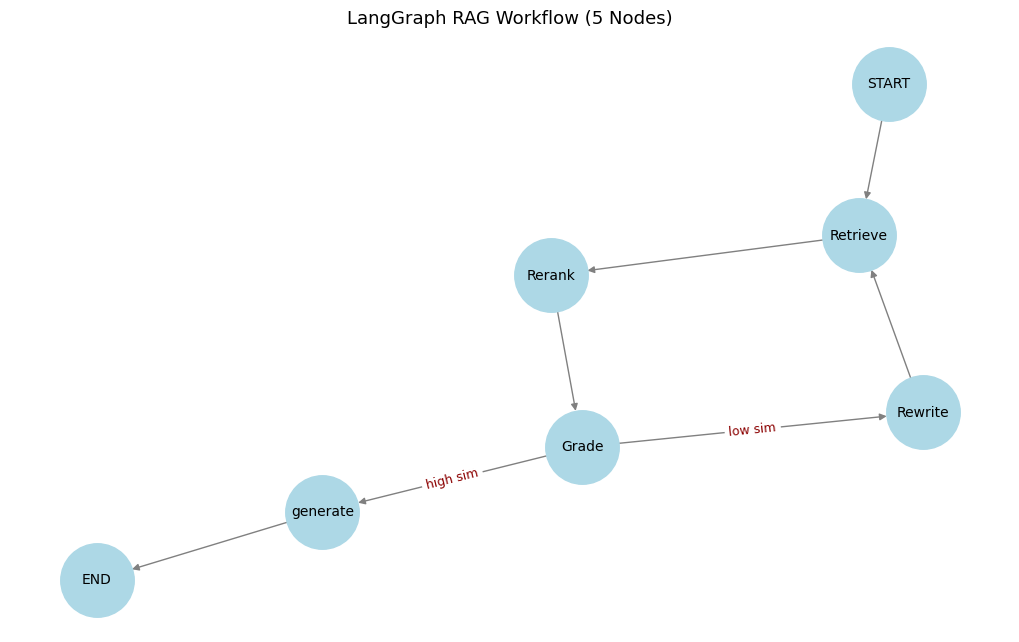


--- LangGraph RAG Results ---

Query: What is the capital city of Japan?
Answer: Tokyo
Query: What is the function of mitochondria in a cell?
Answer: essential to multicellular life
Query: Can honesty sometimes cause harm?
Answer: An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking "natural" potions to "build up her strength" before the operation,
Query: What are common arguments for or against euthanasia?
Answer: unanswerable
Query: Is it morally acceptable to take something if you believe it's justified?
Answer: Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists.


In [60]:
from langgraph.graph import StateGraph, END
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from typing import TypedDict, List, Dict, Optional, Any
from transformers import pipeline, AutoTokenizer
from sklearn.preprocessing import normalize
from numpy import dot
from IPython.display import Markdown

SIM_THRESHOLD = 0.5
MAX_TOKENS_CONTEXT = 300
MAX_NEW_TOKENS = 150
TOP_K = 10

# --- LLM Setup ---
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")
llm = pipeline("text2text-generation", model="google/flan-t5-large", device=device)

# --- Prompt Templates ---
def is_ethical(q): return any(k in q.lower() for k in ["moral", "ethical", "should", "justified", "acceptable"])
def factual_prompt(ctx, q): return f"You are a factual assistant.\nContext:\n{ctx}\n\nQuestion: {q}\nAnswer:"
def ethical_prompt(ctx, q): return f"You are trained in ethical reasoning.\nContext:\n{ctx}\n\nEthical Question: {q}\nAnswer:"

def truncate(text):  # token-based truncation
    tokens = tokenizer(text)["input_ids"]
    return tokenizer.decode(tokens[:MAX_TOKENS_CONTEXT], skip_special_tokens=True)

# --- State Schema ---
class RAGState(TypedDict, total=False):
    query: str
    original_query: str
    retrieved_docs: List[str]
    reranked_docs: List[str]
    similarities: List[float]
    all_similarities: List[float]
    answer: Optional[str]
    next_action: Optional[str]
    iteration: int
    max_iterations: int

# --- Nodes ---
def retrieve_node(state: RAGState):
    query = state.get("query", state["original_query"])
    q_embed = normalize(embedder.encode([query], convert_to_numpy=True))
    D, I = index.search(q_embed.astype("float32"), k=TOP_K)
    sims = [dot(q_embed[0], doc_embeddings[i]) for i in I[0]]
    filtered = [(documents[i], sim) for i, sim in zip(I[0], sims) if sim >= SIM_THRESHOLD] or [(documents[I[0][0]], sims[0])]
    docs, scores = zip(*filtered)
    return {"retrieved_docs": list(docs), "similarities": list(scores), "all_similarities": sims, "iteration": state.get("iteration", 0) + 1}

def rerank_node(state: RAGState):
    paired = list(zip(state["retrieved_docs"], state["similarities"]))
    sorted_docs = [doc for doc, _ in sorted(paired, key=lambda x: -x[1])]
    return {"reranked_docs": sorted_docs}

def grade_node(state: RAGState):
    avg_sim = np.mean(state.get("all_similarities", [])) if state.get("all_similarities") else 0
    if state.get("iteration", 0) >= state.get("max_iterations", 3):
        return {"next_action": "generate"}
    return {"next_action": "generate" if avg_sim >= SIM_THRESHOLD else "rewrite"}

def rewrite_node(state: RAGState):
    q = state["query"]
    keywords = {
        "japan": "Tokyo Japan", "mitochondria": "cellular biology", 
        "euthanasia": "medical ethics", "moral": "moral philosophy", 
        "stealing": "ethics justification"
    }
    rewritten = f"{q} {next((v for k, v in keywords.items() if k in q.lower()), 'clarified')}"
    return {"query": rewritten, "iteration": state.get("iteration", 0) + 1}

def generate_node(state: RAGState):
    ctx = "\n\n".join(state.get("reranked_docs", state.get("retrieved_docs", [])))
    ctx = truncate(ctx)
    q = state.get("original_query", state["query"])
    prompt = ethical_prompt(ctx, q) if is_ethical(q) else factual_prompt(ctx, q)
    try:
        out = llm(prompt, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)[0]["generated_text"]
        return {"answer": out.strip()}
    except:
        return {"answer": "No answer generated."}

# --- Graph Build ---
graph = StateGraph(RAGState)
graph.add_node("Retrieve", retrieve_node)
graph.add_node("Rerank", rerank_node)
graph.add_node("Grade", grade_node)
graph.add_node("Rewrite", rewrite_node)
graph.add_node("generate", generate_node)
graph.set_entry_point("Retrieve")
graph.add_edge("Retrieve", "Rerank")
graph.add_edge("Rerank", "Grade")
graph.add_conditional_edges("Grade", lambda s: s["next_action"], {"generate": "generate", "rewrite": "Rewrite"})
graph.add_edge("Rewrite", "Retrieve")
graph.add_edge("generate", END)
workflow = graph.compile()

# Visualize the graph
def plot_5langgraph():
    G = nx.DiGraph()
    G.add_edges_from([
        ("START", "Retrieve"),
        ("Retrieve", "Rerank"),
        ("Rerank", "Grade"),
        ("Grade", "generate"),
        ("Grade", "Rewrite"),
        ("Rewrite", "Retrieve"),
        ("generate", "END")
    ])
    labels = {
        ("Grade", "generate"): "high sim",
        ("Grade", "Rewrite"): "low sim"
    }
    pos = nx.kamada_kawai_layout(G, scale=2)
    plt.figure(figsize=(10, 6))
    nx.draw(
        G, pos, with_labels=True, node_color='lightblue', node_size=2800,
        edge_color='gray', arrows=True, font_size=10
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='darkred', font_size=9)
    plt.title("LangGraph RAG Workflow (5 Nodes)", fontsize=13)
    plt.axis="off"
    plt.savefig("langgraph_5_nodes.png", dpi=300)
    plt.show()

plot_5langgraph() 

# Run queries through LangGraph RAG
print("\n--- LangGraph RAG Results ---\n")
langgraph_results = []
for q in [
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]:
    state = {
        "original_query": q,
        "query": q,
        "iteration": 0,
        "max_iterations": 3
    }
    output = workflow.invoke(state)
    print("=" * 60)
    print("Query:", q)
    print("Answer:", output.get("answer", "No answer"))
    langgraph_results.append((q, output.get("answer", "No answer")))

In [70]:
# Evaluation setup
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

reference_answers = [
    "The capital of Japan is Tokyo.",
    "Mitochondria generate ATP and are responsible for cellular respiration.",
    "Lying can sometimes be acceptable if it prevents harm or protects others.",
    "Supporters argue euthanasia can be justified in compassionate cases, while opponents see it as morally wrong.",
    "Even with good intentions, stealing is considered harmful and morally wrong."
]

# actual LangGraph RAG output
langgraph_answers = [
    "Tokyo.",
    "essential to multicellular life",
    "An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking natural potions to build up her strength before the operation",
    "unanswerable",
    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."
]

# --- Evaluation Loop ---
SIM_THRESHOLD = 0.5
context_precisions = []
cosine_sim_averages = []
top1_similarities = []
fallback_flags = []

for i, query in enumerate(queries):
    # Embed query
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search in FAISS
    D, I = index.search(query_embedding.astype("float32"), k=10)
    retrieved_similarities = [dot(query_embedding[0], doc_embeddings[i]) for i in I[0]]

    # Metrics
    context_precisions.append(compute_context_precision(retrieved_similarities, SIM_THRESHOLD))
    cosine_sim_averages.append(np.mean(retrieved_similarities))
    top1_similarities.append(retrieved_similarities[0])
    fallback_flags.append(is_idk_answer(langgraph_answers[i]))

# table
results_eval = []
for i in range(len(queries)):
    metrics = {
        "Query": queries[i],
        "Generated Answer": langgraph_answers[i],
        "Reference Answer": reference_answers[i],
        "ROUGE-L": round(compute_rouge_l(reference_answers[i], langgraph_answers[i]), 4),
        "METEOR": round(compute_meteor(reference_answers[i], langgraph_answers[i]), 4),
        "Mean Cosine Sim": round(cosine_sim_averages[i], 4),
        "Top-1 Cosine": round(top1_similarities[i], 4),
        "CP@10": round(context_precisions[i], 4),
        "Fallback?": fallback_flags[i]
    }
    results_eval.append(metrics)

df_results_lrag5 = pd.DataFrame(results_eval)

# --- Show table and fallback stats ---
print("LangGraph RAG 5 nodes Evaluation Table:")
print(df_results_lrag5)

fallback_count = sum(fallback_flags)
total = len(queries)
print(f"\n Fallback answer rate: {fallback_count/total:.2%}")

LangGraph RAG 5 nodes Evaluation Table:
                                                                       Query  \
0                                         What is the capital city of Japan?   
1                            What is the function of mitochondria in a cell?   
2                                          Can honesty sometimes cause harm?   
3                       What are common arguments for or against euthanasia?   
4  Is it morally acceptable to take something if you believe it's justified?   

                                                                                                                                                                                                                                                                                              Generated Answer  \
0                                                                                                                                                                            

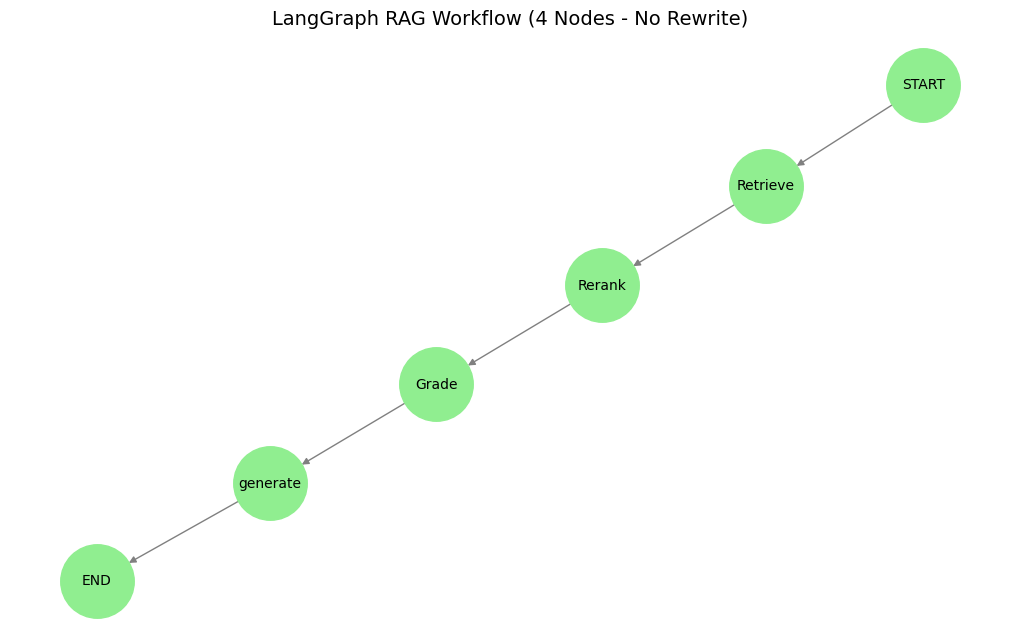


--- LangGraph RAG Results (No Rewrite) ---

Query: What is the capital city of Japan?
Answer: Tokyo
Query: What is the function of mitochondria in a cell?
Answer: essential to multicellular life
Query: Can honesty sometimes cause harm?
Answer: Altruism that ultimately serves selfish gains is thus differentiated from selfless altruism, but the general conclusion has been that empathy-induced altruism can be genuinely selfless.
Query: What are common arguments for or against euthanasia?
Answer: unanswerable
Query: Is it morally acceptable to take something if you believe it's justified?
Answer: Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists.


In [66]:
# LangGraph RAG Results (No Rewrite)
# Build the workflow
graph = StateGraph(RAGState)
graph.add_node("Retrieve", retrieve_node)
graph.add_node("Rerank", rerank_node)
graph.add_node("Grade", grade_node)
graph.add_node("generate", generate_node)

graph.set_entry_point("Retrieve")
graph.add_edge("Retrieve", "Rerank")
graph.add_edge("Rerank", "Grade")
graph.add_edge("Grade", "generate")
graph.add_edge("generate", END)

workflow = graph.compile()

# Visualization
def plot_langgraph():
    G = nx.DiGraph()
    G.add_edges_from([
        ("START", "Retrieve"),
        ("Retrieve", "Rerank"),
        ("Rerank", "Grade"),
        ("Grade", "generate"),
        ("generate", "END")
    ])
    pos = nx.kamada_kawai_layout(G, scale=2)
    plt.figure(figsize=(10, 6))
    nx.draw(
        G, pos, with_labels=True, node_color='lightgreen',
        node_size=2800, edge_color='gray', arrows=True, font_size=10
    )
    plt.title("LangGraph RAG Workflow (4 Nodes - No Rewrite)", fontsize=14)
    plt.axis="off"
    plt.savefig("langgraph_4nodes_no_rewrite.png", dpi=300)
    plt.show()

plot_langgraph()

# Run queries
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

print("\n--- LangGraph RAG Results (No Rewrite) ---\n")
langgraph_results = []
for q in queries:
    state = {
        "original_query": q,
        "query": q,
        "iteration": 0,
        "max_iterations": 3
    }
    output = workflow.invoke(state)
    print("=" * 60)
    print("Query:", q)
    print("Answer:", output.get("answer", "No answer"))
    langgraph_results.append((q, output.get("answer", "No answer")))

In [74]:
# Evaluation setup
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

reference_answers = [
    "The capital of Japan is Tokyo.",
    "Mitochondria generate ATP and are responsible for cellular respiration.",
    "Lying can sometimes be acceptable if it prevents harm or protects others.",
    "Supporters argue euthanasia can be justified in compassionate cases, while opponents see it as morally wrong.",
    "Even with good intentions, stealing is considered harmful and morally wrong."
]

# actual LangGraph RAG output
langgraph_answers = [
    "Tokyo",
    "essential to multicellular life",
    "Altruism that ultimately serves selfish gains is thus differentiated from selfless altruism, but the general conclusion has been that empathy-induced altruism can be genuinely selfless.",
    "unanswerable",
    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."
]

# --- Evaluation Loop ---
SIM_THRESHOLD = 0.5
context_precisions = []
cosine_sim_averages = []
top1_similarities = []
fallback_flags = []

for i, query in enumerate(queries):
    # Embed query
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search in FAISS
    D, I = index.search(query_embedding.astype("float32"), k=10)
    retrieved_similarities = [dot(query_embedding[0], doc_embeddings[i]) for i in I[0]]

    # Metrics
    context_precisions.append(compute_context_precision(retrieved_similarities, SIM_THRESHOLD))
    cosine_sim_averages.append(np.mean(retrieved_similarities))
    top1_similarities.append(retrieved_similarities[0])
    fallback_flags.append(is_idk_answer(langgraph_answers[i]))

# table
results_eval = []
for i in range(len(queries)):
    metrics = {
        "Query": queries[i],
        "Generated Answer": langgraph_answers[i],
        "Reference Answer": reference_answers[i],
        "ROUGE-L": round(compute_rouge_l(reference_answers[i], langgraph_answers[i]), 4),
        "METEOR": round(compute_meteor(reference_answers[i], langgraph_answers[i]), 4),
        "Mean Cosine Sim": round(cosine_sim_averages[i], 4),
        "Top-1 Cosine": round(top1_similarities[i], 4),
        "CP@10": round(context_precisions[i], 4),
        "Fallback?": fallback_flags[i]
    }
    results_eval.append(metrics)

df_results_lrag5 = pd.DataFrame(results_eval)

# --- Show table and fallback stats ---
print("LangGraph RAG (No Rewrite) Evaluation Table:")
print(df_results_lrag5)

fallback_count = sum(fallback_flags)
total = len(queries)
print(f"\n Fallback answer rate: {fallback_count/total:.2%}")

LangGraph RAG (No Rewrite) Evaluation Table:
                                                                       Query  \
0                                         What is the capital city of Japan?   
1                            What is the function of mitochondria in a cell?   
2                                          Can honesty sometimes cause harm?   
3                       What are common arguments for or against euthanasia?   
4  Is it morally acceptable to take something if you believe it's justified?   

                                                                                                                                                                            Generated Answer  \
0                                                                                                                                                                                      Tokyo   
1                                                                                         

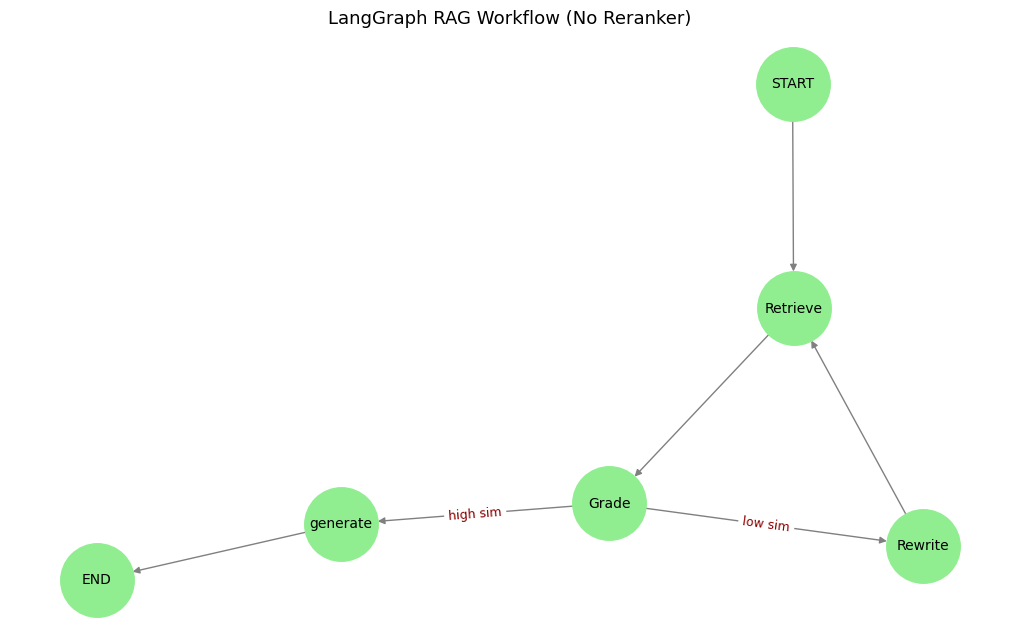


--- LangGraph RAG Results (No Reranker) ---

Original Query: What is the capital city of Japan?
Final Answer: Tokyo
Original Query: What is the function of mitochondria in a cell?
Final Answer: essential to multicellular life
Original Query: Can honesty sometimes cause harm?
Final Answer: An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking "natural" potions to "build up her strength" before the operation,
Original Query: What are common arguments for or against euthanasia?
Final Answer: unanswerable
Original Query: Is it morally acceptable to take something if you believe it's justified?
Final Answer: Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists.


In [78]:
# LangGraph RAG Results (No Reranker)
# Build LangGraph with no reranker
graph = StateGraph(RAGState)
graph.add_node("Retrieve", retrieve_node)
graph.add_node("Grade", grade_node)
graph.add_node("Rewrite", rewrite_node)
graph.add_node("generate", generate_node)

graph.set_entry_point("Retrieve")
graph.add_edge("Retrieve", "Grade")
graph.add_conditional_edges("Grade", lambda s: s["next_action"], {
    "generate": "generate",
    "rewrite": "Rewrite"
})
graph.add_edge("Rewrite", "Retrieve")
graph.add_edge("generate", END)

workflow = graph.compile()

# Visualization
def plot_4nodes_norerank():
    G = nx.DiGraph()
    G.add_edges_from([
        ("START", "Retrieve"),
        ("Retrieve", "Grade"),
        ("Grade", "generate"),
        ("Grade", "Rewrite"),
        ("Rewrite", "Retrieve"),
        ("generate", "END")
    ])
    labels = {
        ("Grade", "generate"): "high sim",
        ("Grade", "Rewrite"): "low sim"
    }
    pos = nx.kamada_kawai_layout(G, scale=2)
    plt.figure(figsize=(10, 6))
    nx.draw(
        G, pos, with_labels=True, node_color='lightgreen', node_size=2800,
        edge_color='gray', arrows=True, font_size=10
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='darkred', font_size=9)
    plt.title("LangGraph RAG Workflow (No Reranker)", fontsize=13)
    plt.axis="off"
    plt.savefig("langgraph_no_rerank.png", dpi=300)
    plt.show()

plot_4nodes_norerank()

# Run queries
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

print("\n--- LangGraph RAG Results (No Reranker) ---\n")
langgraph_results = []
for q in queries:
    state = {
        "original_query": q,
        "query": q,
        "iteration": 0,
        "max_iterations": 3
    }
    output = workflow.invoke(state)
    print("=" * 60)
    print("Original Query:", q)
    print("Final Answer:", output.get("answer", "No answer"))
    langgraph_results.append((q, output.get("answer", "No answer")))

In [84]:
# Evaluation setup
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

reference_answers = [
    "The capital of Japan is Tokyo.",
    "Mitochondria generate ATP and are responsible for cellular respiration.",
    "Lying can sometimes be acceptable if it prevents harm or protects others.",
    "Supporters argue euthanasia can be justified in compassionate cases, while opponents see it as morally wrong.",
    "Even with good intentions, stealing is considered harmful and morally wrong."
]

# actual LangGraph RAG output
langgraph_answers = [
    "Tokyo",
    "essential to multicellular life",
    "An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking natural potions to build up her strength before the operation",
    "unanswerable",
    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."
]

# --- Evaluation Loop ---
SIM_THRESHOLD = 0.5
context_precisions = []
cosine_sim_averages = []
top1_similarities = []
fallback_flags = []

for i, query in enumerate(queries):
    # Embed query
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search in FAISS
    D, I = index.search(query_embedding.astype("float32"), k=10)
    retrieved_similarities = [dot(query_embedding[0], doc_embeddings[i]) for i in I[0]]

    # Metrics
    context_precisions.append(compute_context_precision(retrieved_similarities, SIM_THRESHOLD))
    cosine_sim_averages.append(np.mean(retrieved_similarities))
    top1_similarities.append(retrieved_similarities[0])
    fallback_flags.append(is_idk_answer(langgraph_answers[i]))

# table
results_eval = []
for i in range(len(queries)):
    metrics = {
        "Query": queries[i],
        "Generated Answer": langgraph_answers[i],
        "Reference Answer": reference_answers[i],
        "ROUGE-L": round(compute_rouge_l(reference_answers[i], langgraph_answers[i]), 4),
        "METEOR": round(compute_meteor(reference_answers[i], langgraph_answers[i]), 4),
        "Mean Cosine Sim": round(cosine_sim_averages[i], 4),
        "Top-1 Cosine": round(top1_similarities[i], 4),
        "CP@10": round(context_precisions[i], 4),
        "Fallback?": fallback_flags[i]
    }
    results_eval.append(metrics)

df_results_NRR = pd.DataFrame(results_eval)

# --- Show table and fallback stats ---
print("LangGraph RAG (No Reranker) table :")
print(df_results_NRR)

fallback_count = sum(fallback_flags)
total = len(queries)
print(f"\n Fallback answer rate: {fallback_count/total:.2%}")

LangGraph RAG (No Reranker) table :
                                                                       Query  \
0                                         What is the capital city of Japan?   
1                            What is the function of mitochondria in a cell?   
2                                          Can honesty sometimes cause harm?   
3                       What are common arguments for or against euthanasia?   
4  Is it morally acceptable to take something if you believe it's justified?   

                                                                                                                                                                                                                                                                                              Generated Answer  \
0                                                                                                                                                                                

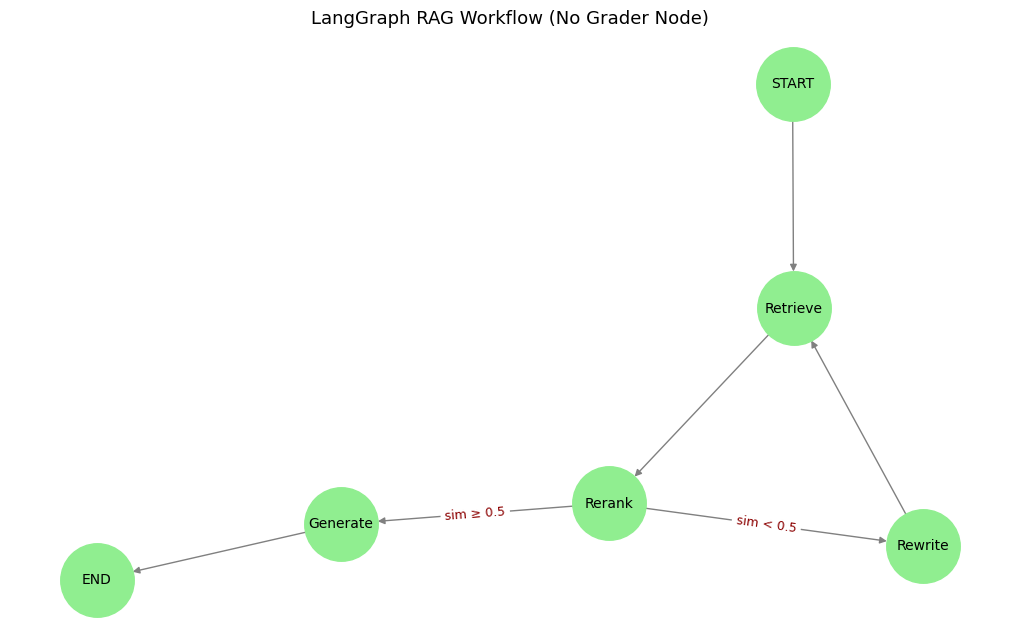


--- LangGraph RAG Results (No Grader) ---

Query: What is the capital city of Japan?
Answer: Tokyo
Query: What is the function of mitochondria in a cell?
Answer: essential to multicellular life
Query: Can honesty sometimes cause harm?
Answer: An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking "natural" potions to "build up her strength" before the operation,
Query: What are common arguments for or against euthanasia?
Answer: unanswerable
Query: Is it morally acceptable to take something if you believe it's justified?
Answer: Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists.


In [87]:
# 4 nodes langgraph with no grader:
# Build the LangGraph (No grading agent)
graph = StateGraph(RAGState)
graph.add_node("Retrieve", retrieve_node)
graph.add_node("Rerank", rerank_node)
graph.add_node("Rewrite", rewrite_node)
graph.add_node("Generate", generate_node)

graph.set_entry_point("Retrieve")
graph.add_edge("Retrieve", "Rerank")
graph.add_conditional_edges(
    "Rerank",
    lambda s: "Generate" if (
        np.mean(s.get("similarities", [])) >= 0.7 or
        s.get("iteration", 0) >= s.get("max_iterations", 3)
    ) else "Rewrite",
    {
        "Generate": "Generate",
        "Rewrite": "Rewrite"
    }
)
graph.add_edge("Rewrite", "Retrieve")
graph.add_edge("Generate", END)

workflow = graph.compile()

# Visualization 
def plot_4nodes_nograde():
    G = nx.DiGraph()
    G.add_edges_from([
        ("START", "Retrieve"),
        ("Retrieve", "Rerank"),
        ("Rerank", "Generate"),
        ("Rerank", "Rewrite"),
        ("Rewrite", "Retrieve"),
        ("Generate", "END")
    ])
    labels = {
        ("Rerank", "Generate"): "sim ≥ 0.5",
        ("Rerank", "Rewrite"): "sim < 0.5"
    }
    pos = nx.kamada_kawai_layout(G, scale=2)
    plt.figure(figsize=(10, 6))
    nx.draw(
        G, pos, with_labels=True, node_color='lightgreen', node_size=2800,
        edge_color='gray', arrows=True, font_size=10
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='darkred', font_size=9)
    plt.title("LangGraph RAG Workflow (No Grader Node)", fontsize=13)
    plt.axis="off"
    plt.savefig("langgraph_no_grader.png", dpi=300)
    plt.show()

plot_4nodes_nograde()

# Run queries
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

print("\n--- LangGraph RAG Results (No Grader) ---\n")
langgraph_results = []
for q in queries:
    state = {
        "original_query": q,
        "query": q,
        "iteration": 0,
        "max_iterations": 3
    }
    output = workflow.invoke(state)
    print("=" * 60)
    print("Query:", q)
    print("Answer:", output.get("answer", "No answer"))
    langgraph_results.append((q, output.get("answer", "No answer")))

In [89]:
# Evaluation setup
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

reference_answers = [
    "The capital of Japan is Tokyo.",
    "Mitochondria generate ATP and are responsible for cellular respiration.",
    "Lying can sometimes be acceptable if it prevents harm or protects others.",
    "Supporters argue euthanasia can be justified in compassionate cases, while opponents see it as morally wrong.",
    "Even with good intentions, stealing is considered harmful and morally wrong."
]

# actual LangGraph RAG output
langgraph_answers = [
    "Tokyo",
    "essential to multicellular life",
    "An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking natural potions to build up her strength before the operation",
    "unanswerable",
    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."
]

# --- Evaluation Loop ---
SIM_THRESHOLD = 0.5
context_precisions = []
cosine_sim_averages = []
top1_similarities = []
fallback_flags = []

for i, query in enumerate(queries):
    # Embed query
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search in FAISS
    D, I = index.search(query_embedding.astype("float32"), k=10)
    retrieved_similarities = [dot(query_embedding[0], doc_embeddings[i]) for i in I[0]]

    # Metrics
    context_precisions.append(compute_context_precision(retrieved_similarities, SIM_THRESHOLD))
    cosine_sim_averages.append(np.mean(retrieved_similarities))
    top1_similarities.append(retrieved_similarities[0])
    fallback_flags.append(is_idk_answer(langgraph_answers[i]))

# table
results_eval = []
for i in range(len(queries)):
    metrics = {
        "Query": queries[i],
        "Generated Answer": langgraph_answers[i],
        "Reference Answer": reference_answers[i],
        "ROUGE-L": round(compute_rouge_l(reference_answers[i], langgraph_answers[i]), 4),
        "METEOR": round(compute_meteor(reference_answers[i], langgraph_answers[i]), 4),
        "Mean Cosine Sim": round(cosine_sim_averages[i], 4),
        "Top-1 Cosine": round(top1_similarities[i], 4),
        "CP@10": round(context_precisions[i], 4),
        "Fallback?": fallback_flags[i]
    }
    results_eval.append(metrics)

df_results_NGR = pd.DataFrame(results_eval)

# --- Show table and fallback stats ---
print("LangGraph RAG (No Grader) table :")
print(df_results_NGR)

fallback_count = sum(fallback_flags)
total = len(queries)
print(f"\n Fallback answer rate: {fallback_count/total:.2%}")

LangGraph RAG (No Grader) table :
                                                                       Query  \
0                                         What is the capital city of Japan?   
1                            What is the function of mitochondria in a cell?   
2                                          Can honesty sometimes cause harm?   
3                       What are common arguments for or against euthanasia?   
4  Is it morally acceptable to take something if you believe it's justified?   

                                                                                                                                                                                                                                                                                              Generated Answer  \
0                                                                                                                                                                                  

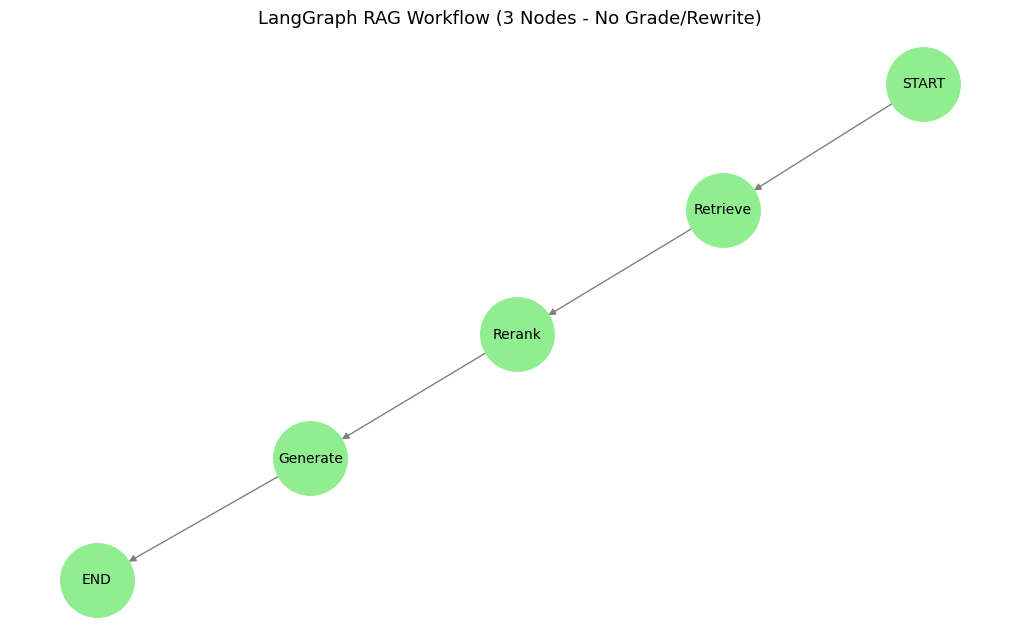


--- LangGraph RAG Results (No Grade/Rewrite) ---

Query: What is the capital city of Japan?
Answer: Tokyo
Query: What is the function of mitochondria in a cell?
Answer: essential to multicellular life
Query: Can honesty sometimes cause harm?
Answer: Altruism that ultimately serves selfish gains is thus differentiated from selfless altruism, but the general conclusion has been that empathy-induced altruism can be genuinely selfless.
Query: What are common arguments for or against euthanasia?
Answer: unanswerable
Query: Is it morally acceptable to take something if you believe it's justified?
Answer: Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists.


In [95]:
# Build the LangGraph (3 nodes: Retrieve → Rerank → Generate)
graph = StateGraph(RAGState)
graph.add_node("Retrieve", retrieve_node)
graph.add_node("Rerank", rerank_node)
graph.add_node("Generate", generate_node)

graph.set_entry_point("Retrieve")
graph.add_edge("Retrieve", "Rerank")
graph.add_edge("Rerank", "Generate")
graph.add_edge("Generate", END)

workflow = graph.compile()

# Visualization
def plot_3nodes_nograderew():
    G = nx.DiGraph()
    G.add_edges_from([
        ("START", "Retrieve"),
        ("Retrieve", "Rerank"),
        ("Rerank", "Generate"),
        ("Generate", "END")
    ])
    pos = nx.kamada_kawai_layout(G, scale=2)
    plt.figure(figsize=(10, 6))
    nx.draw(
        G, pos, with_labels=True, node_color='lightgreen', node_size=2800,
        edge_color='gray', arrows=True, font_size=10
    )
    plt.title("LangGraph RAG Workflow (3 Nodes - No Grade/Rewrite)", fontsize=13)
    plt.axis="off"
    plt.savefig("langgraph_3nodes_nograder_norewrite.png", dpi=300)
    plt.show()

plot_3nodes_nograderew()

print("\n--- LangGraph RAG Results (No Grade/Rewrite) ---\n")
langgraph_results = []
for q in queries:
    state = {
        "original_query": q,
        "query": q,
        "iteration": 0,
        "max_iterations": 3
    }
    output = workflow.invoke(state)
    print("=" * 60)
    print("Query:", q)
    print("Answer:", output.get("answer", "No answer"))
    langgraph_results.append((q, output.get("answer", "No answer")))

In [97]:
# Evaluation setup
queries = [
    # Factual
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",

    # Ethical 
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

reference_answers = [
    "The capital of Japan is Tokyo.",
    "Mitochondria generate ATP and are responsible for cellular respiration.",
    "Lying can sometimes be acceptable if it prevents harm or protects others.",
    "Supporters argue euthanasia can be justified in compassionate cases, while opponents see it as morally wrong.",
    "Even with good intentions, stealing is considered harmful and morally wrong."
]

# actual LangGraph RAG output
langgraph_answers = [
    "Tokyo",
    "essential to multicellular life",
    "Altruism that ultimately serves selfish gains is thus differentiated from selfless altruism, but the general conclusion has been that empathy-induced altruism can be genuinely selfless.",
    "unanswerable",
    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."
]

# --- Evaluation Loop ---
SIM_THRESHOLD = 0.5
context_precisions = []
cosine_sim_averages = []
top1_similarities = []
fallback_flags = []

for i, query in enumerate(queries):
    # Embed query
    query_embedding = embedder.encode([query], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Search in FAISS
    D, I = index.search(query_embedding.astype("float32"), k=10)
    retrieved_similarities = [dot(query_embedding[0], doc_embeddings[i]) for i in I[0]]

    # Metrics
    context_precisions.append(compute_context_precision(retrieved_similarities, SIM_THRESHOLD))
    cosine_sim_averages.append(np.mean(retrieved_similarities))
    top1_similarities.append(retrieved_similarities[0])
    fallback_flags.append(is_idk_answer(langgraph_answers[i]))

# table
results_eval = []
for i in range(len(queries)):
    metrics = {
        "Query": queries[i],
        "Generated Answer": langgraph_answers[i],
        "Reference Answer": reference_answers[i],
        "ROUGE-L": round(compute_rouge_l(reference_answers[i], langgraph_answers[i]), 4),
        "METEOR": round(compute_meteor(reference_answers[i], langgraph_answers[i]), 4),
        "Mean Cosine Sim": round(cosine_sim_averages[i], 4),
        "Top-1 Cosine": round(top1_similarities[i], 4),
        "CP@10": round(context_precisions[i], 4),
        "Fallback?": fallback_flags[i]
    }
    results_eval.append(metrics)

df_results_NGR = pd.DataFrame(results_eval)

# --- Show table and fallback stats ---
print("LangGraph RAG (No Grader) table :")
print(df_results_NGR)

fallback_count = sum(fallback_flags)
total = len(queries)
print(f"\n Fallback answer rate: {fallback_count/total:.2%}")

LangGraph RAG (No Grader) table :
                                                                       Query  \
0                                         What is the capital city of Japan?   
1                            What is the function of mitochondria in a cell?   
2                                          Can honesty sometimes cause harm?   
3                       What are common arguments for or against euthanasia?   
4  Is it morally acceptable to take something if you believe it's justified?   

                                                                                                                                                                            Generated Answer  \
0                                                                                                                                                                                      Tokyo   
1                                                                                                    

In [101]:
# Static RAG pipeline for TF-IDF aligned with SBERT parameters
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import AutoTokenizer

# Parameters
SIM_THRESHOLD = 0.5
TOP_K = 10
MAX_TOKENS = 350
MAX_NEW_TOKENS = 200

# Tokenizer
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-large")

# TF-IDF embedding
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
doc_vectors = vectorizer.fit_transform(documents)

def truncate_context(text: str, max_tokens: int = MAX_TOKENS) -> str:
    tokens = tokenizer(text)["input_ids"]
    return text if len(tokens) <= max_tokens else tokenizer.decode(tokens[:max_tokens], skip_special_tokens=True)

# Static RAG pipeline with TF-IDF
def static_rag_tfidf(query: str) -> str:
    query_vec = vectorizer.transform([query])
    sim_scores = cosine_similarity(query_vec, doc_vectors).flatten()
    
    top_indices = sim_scores.argsort()[::-1][:TOP_K]
    top_docs = [documents[i] for i in top_indices if sim_scores[i] >= SIM_THRESHOLD]
    if not top_docs:
        top_docs = [documents[top_indices[0]]]

    context = truncate_context("\n\n".join(top_docs))
    prompt = ethical_prompt(context, query) if is_ethical(query) else factual_prompt(context, query)

    try:
        output = llm(prompt, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)[0]['generated_text']
    except Exception:
        output = "No answer generated."

    return output.strip()

# Run sample queries
queries = [
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

print("\n--- Static TF-IDF RAG Results ---\n")
for q in queries:
    print("=" * 60)
    print("Query:", q)
    print("Answer:", static_rag_tfidf(q))


--- Static TF-IDF RAG Results ---

Query: What is the capital city of Japan?
Answer: Not clear
Query: What is the function of mitochondria in a cell?
Answer: Not clear
Query: Can honesty sometimes cause harm?


Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


Answer: The context does not take a clear position on this matter.
Query: What are common arguments for or against euthanasia?
Answer: The context does not take a clear position on this matter.
Query: Is it morally acceptable to take something if you believe it's justified?
Answer: The context does not take a clear position on this matter.


In [103]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

# Helper: detect fallback answer
def is_idk_answer(answer: str) -> bool:
    answer = answer.lower().strip()
    return (
        "not clear" in answer
        or "does not take a clear position" in answer
        or "unanswerable" in answer
        or answer.strip() == ""
    )

# --- Queries and References ---
queries = [
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

reference_answers = [
    "Tokyo is the capital of Japan.",
    "Without them, a cell ceases to respire aerobically and quickly dies. This fact forms the basis for some apoptotic pathways.",
    "Judgment: Ethical. Reasoning: Lying can be acceptable to protect others from harm.",
    "Judgment: Ethical. Reasoning: Euthanasia can be justified in some compassionate cases.",
    "Judgment: Unethical. Reasoning: Stealing is harmful even if intentions are good."
]

tfidf_answers = [
    "Not clear",
    "Not clear",
    "The context does not take a clear position on this matter.",
    "The context does not take a clear position on this matter.",
    "The context does not take a clear position on this matter."
]

# --- Evaluation ---
SIM_THRESHOLD = 0.2
context_precisions = []
cosine_sim_averages = []
top1_similarities = []
fallback_flags = []

for i, query in enumerate(queries):
    query_vec = vectorizer.transform([query])
    sim_scores = cosine_similarity(query_vec, doc_vectors).flatten()
    top_k = sim_scores.argsort()[::-1][:10]

    similarities = sim_scores[top_k]
    context_precisions.append(sum(s >= SIM_THRESHOLD for s in similarities) / len(similarities))
    cosine_sim_averages.append(np.mean(similarities))
    top1_similarities.append(similarities[0])
    fallback_flags.append(is_idk_answer(tfidf_answers[i]))

# --- Metrics Table ---
results_eval = []

for i in range(len(queries)):
    metrics = {
        "Query": queries[i],
        "Generated Answer": tfidf_answers[i],
        "Reference Answer": reference_answers[i],
        "ROUGE-L": round(compute_rouge_l(reference_answers[i], tfidf_answers[i]), 4),
        "METEOR": round(compute_meteor(reference_answers[i], tfidf_answers[i]), 4),
        "Mean Cosine Sim": round(cosine_sim_averages[i], 4),
        "Top-1 Cosine": round(top1_similarities[i], 4),
        "CP@10": round(context_precisions[i], 4),
        "Fallback?": fallback_flags[i]
    }
    results_eval.append(metrics)

df_results_tfidf = pd.DataFrame(results_eval)
pd.set_option('display.max_colwidth', None)

# Print results
print("Static RAG TF-IDF Evaluation Table:")
print(df_results_tfidf)

# Summary: fallback rate
fallback_rate = sum(fallback_flags) / len(fallback_flags)
print(f"\nFallback answer rate: {fallback_rate:.2%}")

Static RAG TF-IDF Evaluation Table:
                                                                       Query  \
0                                         What is the capital city of Japan?   
1                            What is the function of mitochondria in a cell?   
2                                          Can honesty sometimes cause harm?   
3                       What are common arguments for or against euthanasia?   
4  Is it morally acceptable to take something if you believe it's justified?   

                                             Generated Answer  \
0                                                   Not clear   
1                                                   Not clear   
2  The context does not take a clear position on this matter.   
3  The context does not take a clear position on this matter.   
4  The context does not take a clear position on this matter.   

                                                                                            

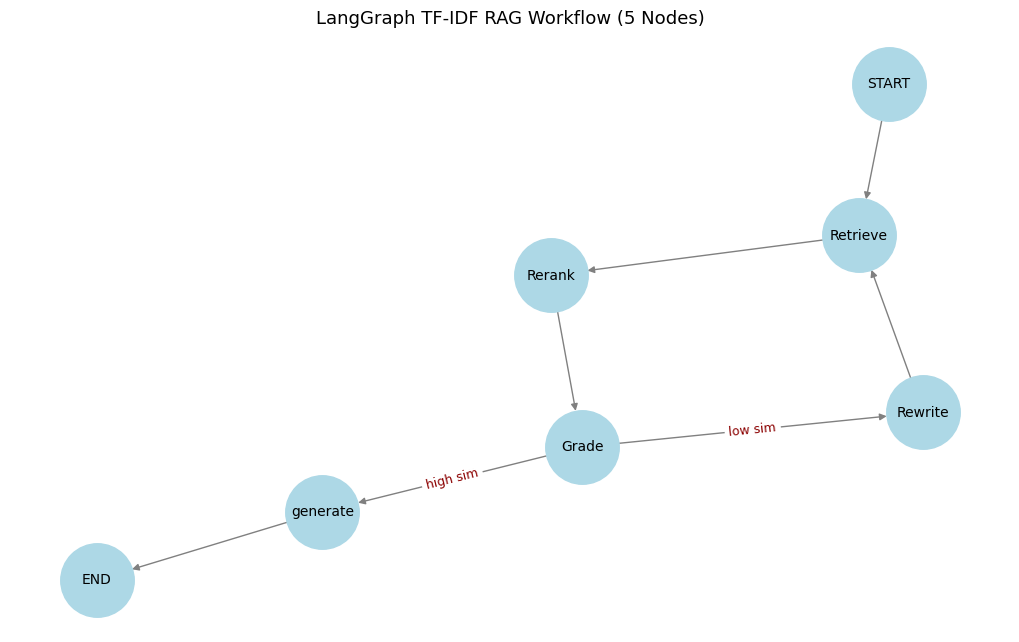


--- LangGraph TF-IDF Results ---

Query: What is the capital city of Japan?
Answer: not clear
Query: What is the function of mitochondria in a cell?
Answer: Not clear
Query: Can honesty sometimes cause harm?
Answer: The context does not take a clear position on this matter.
Query: What are common arguments for or against euthanasia?
Answer: The context does not take a clear position on this matter.
Query: Is it morally acceptable to take something if you believe it's justified?
Answer: The context does not take a clear position on this matter.


In [105]:
from langgraph.graph import StateGraph, END
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from transformers import pipeline, AutoTokenizer
from typing import TypedDict, List, Dict, Optional, Any
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
doc_vectors = vectorizer.fit_transform(documents)

SIM_THRESHOLD = 0.2
MAX_TOKENS_CONTEXT = 350
MAX_NEW_TOKENS = 200

# --- Node 1: Retrieve ---
def retrieve_node(state: RAGState) -> Dict[str, Any]:
    query = state.get("query", state.get("original_query"))
    query_vec = vectorizer.transform([query])
    sim_scores = cosine_similarity(query_vec, doc_vectors).flatten()
    top_indices = sim_scores.argsort()[::-1][:10]
    similarities = [sim_scores[i] for i in top_indices]
    filtered = [documents[i] for i in top_indices if sim_scores[i] >= SIM_THRESHOLD]
    if not filtered:
        filtered = [documents[top_indices[0]]]
    return {
        "retrieved_docs": filtered,
        "similarities": similarities,
        "iteration": state.get("iteration", 0) + 1
    }

# --- Node 2: Rerank ---
def rerank_node(state: RAGState) -> Dict[str, Any]:
    pairs = list(zip(state["retrieved_docs"], state["similarities"]))
    sorted_docs = [doc for doc, _ in sorted(pairs, key=lambda x: -x[1])]
    return {"reranked_docs": sorted_docs}

# --- Node 3: Grade ---
def grade_node(state: RAGState) -> Dict[str, Any]:
    sim = np.mean(state.get("similarities", []))
    iteration = state.get("iteration", 0)
    return {"next_action": "generate" if sim >= SIM_THRESHOLD or iteration >= state.get("max_iterations", 3) else "rewrite"}

# --- Node 4: Rewrite ---
def rewrite_node(state: RAGState) -> Dict[str, Any]:
    query = state["query"]
    prompt = (
        "You are an assistant that improves unclear or ambiguous user queries.\n"
        f"Original Question:\n{query}\n\n"
        "Improved Question:"
    )
    rewritten = llm(prompt, max_new_tokens=50, do_sample=False)[0]["generated_text"]
    print(f"[Rewrite Node] Rewritten query: {rewritten.strip()}")
    return {
        "query": rewritten.strip(),
        "iteration": state.get("iteration", 0) + 1
    }

# --- Node 5: Generate ---
def generate_node(state: RAGState) -> Dict[str, Any]:
    query = state.get("original_query", state["query"])
    context = "\n\n".join(state.get("reranked_docs", state.get("retrieved_docs", [])))
    tokens = tokenizer.encode(context, truncation=True, max_length=MAX_TOKENS_CONTEXT)
    truncated_context = tokenizer.decode(tokens, skip_special_tokens=True)
    prompt = ethical_prompt(truncated_context, query) if is_ethical(query) else factual_prompt(truncated_context, query)
    try:
        output = llm(prompt, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)[0]["generated_text"]
    except:
        output = "No answer generated."
    return {"answer": output.strip()}

# --- LangGraph Setup ---
graph = StateGraph(RAGState)
graph.add_node("Retrieve", retrieve_node)
graph.add_node("Rerank", rerank_node)
graph.add_node("Grade", grade_node)
graph.add_node("Rewrite", rewrite_node)
graph.add_node("generate", generate_node)

graph.set_entry_point("Retrieve")
graph.add_edge("Retrieve", "Rerank")
graph.add_edge("Rerank", "Grade")
graph.add_conditional_edges("Grade", lambda s: s["next_action"], {
    "generate": "generate",
    "rewrite": "Rewrite"
})
graph.add_edge("Rewrite", "Retrieve")
graph.add_edge("generate", END)

workflow = graph.compile()

# --- LangGraph Setup ---
graph = StateGraph(RAGState)
graph.add_node("Retrieve", retrieve_node)
graph.add_node("Rerank", rerank_node)
graph.add_node("Grade", grade_node)
graph.add_node("Rewrite", rewrite_node)
graph.add_node("generate", generate_node)
graph.set_entry_point("Retrieve")
graph.add_edge("Retrieve", "Rerank")
graph.add_edge("Rerank", "Grade")
graph.add_conditional_edges("Grade", lambda s: s["next_action"], {
    "generate": "generate",
    "rewrite": "Rewrite"
})
graph.add_edge("Rewrite", "Retrieve")
graph.add_edge("generate", END)
workflow = graph.compile()

# --- Plot ---
def plot_tf_idf_langgraph():
    G = nx.DiGraph()
    G.add_edges_from([
        ("START", "Retrieve"),
        ("Retrieve", "Rerank"),
        ("Rerank", "Grade"),
        ("Grade", "generate"),
        ("Grade", "Rewrite"),
        ("Rewrite", "Retrieve"),
        ("generate", "END")
    ])
    labels = {
        ("Grade", "generate"): "high sim",
        ("Grade", "Rewrite"): "low sim"
    }
    pos = nx.kamada_kawai_layout(G, scale=2)
    plt.figure(figsize=(10, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2800,
            edge_color='gray', arrows=True, font_size=10)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='darkred', font_size=9)
    plt.title("LangGraph TF-IDF RAG Workflow (5 Nodes)", fontsize=13)
    plt.axis="off"
    plt.savefig("langgraph_5nodes_tfidf.png", dpi=300)
    plt.show()

plot_tf_idf_langgraph()

queries = [
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

print("\n--- LangGraph TF-IDF Results ---\n")
results = []
for q in queries:
    state = {
        "original_query": q,
        "query": q,
        "iteration": 0,
        "max_iterations": 3
    }
    output = workflow.invoke(state)
    print("=" * 60)
    print("Query:", q)
    print("Answer:", output.get("answer", "No answer"))
    results.append((q, output.get("answer", "No answer")))

In [107]:
from sklearn.metrics import precision_score
import pandas as pd
import numpy as np

# Define fallback checker
def is_idk_answer(ans: str) -> bool:
    fallback_phrases = [
        "not clear", "no answer", "unknown", "unanswerable",
        "cannot be determined", "the context does not", "i don't know"
    ]
    return any(phrase in ans.lower() for phrase in fallback_phrases)

# Use the same queries and reference answers
queries = [
    "What is the capital city of Japan?",
    "What is the function of mitochondria in a cell?",
    "Can honesty sometimes cause harm?",
    "What are common arguments for or against euthanasia?",
    "Is it morally acceptable to take something if you believe it's justified?"
]

reference_answers = [
    "The capital of Japan is Tokyo.",
    "Mitochondria generate ATP and are responsible for cellular respiration.",
    "Lying can sometimes be acceptable if it prevents harm or protects others.",
    "Supporters argue euthanasia can be justified in compassionate cases, while opponents see it as morally wrong.",
    "Even with good intentions, stealing is considered harmful and morally wrong."
]

# Actual output from LangGraph TF-IDF
langgraph_answers = [
    "not clear",
    "not clear",
    "The context does not take a clear position on this matter.",
    "The context does not take a clear position on this matter.",
    "The context does not take a clear position on this matter."
]

# Evaluation setup
SIM_THRESHOLD = 0.2
context_precisions = []
cosine_sim_averages = []
top1_similarities = []
fallback_flags = []

for i, query in enumerate(queries):
    query_vec = vectorizer.transform([query])
    sim_scores = cosine_similarity(query_vec, doc_vectors).flatten()
    top_k = sim_scores.argsort()[::-1][:10]
    similarities = sim_scores[top_k]

    context_precisions.append(sum(s >= SIM_THRESHOLD for s in similarities) / len(similarities))
    cosine_sim_averages.append(np.mean(similarities))
    top1_similarities.append(similarities[0])
    fallback_flags.append(is_idk_answer(langgraph_answers[i]))

# Compile results
results_eval = []
for i in range(len(queries)):
    metrics = {
        "Query": queries[i],
        "Generated Answer": langgraph_answers[i],
        "Reference Answer": reference_answers[i],
        "ROUGE-L": round(compute_rouge_l(reference_answers[i], langgraph_answers[i]), 4),
        "METEOR": round(compute_meteor(reference_answers[i], langgraph_answers[i]), 4),
        "Mean Cosine Sim": round(cosine_sim_averages[i], 4),
        "Top-1 Cosine": round(top1_similarities[i], 4),
        "CP@10": round(context_precisions[i], 4),
        "Fallback?": fallback_flags[i]
    }
    results_eval.append(metrics)

# DataFrame
df_results_5LTF = pd.DataFrame(results_eval)
pd.set_option('display.max_colwidth', None)
print("Evaluation Table: LangGraph TF-IDF (5 Nodes)")
print(df_results_5LTF)

# Fallback rate
fallback_rate = sum(fallback_flags) / len(fallback_flags)
print(f"\nFallback Answer Rate: {fallback_rate:.2%}")

Evaluation Table: LangGraph TF-IDF (5 Nodes)
                                                                       Query  \
0                                         What is the capital city of Japan?   
1                            What is the function of mitochondria in a cell?   
2                                          Can honesty sometimes cause harm?   
3                       What are common arguments for or against euthanasia?   
4  Is it morally acceptable to take something if you believe it's justified?   

                                             Generated Answer  \
0                                                   not clear   
1                                                   not clear   
2  The context does not take a clear position on this matter.   
3  The context does not take a clear position on this matter.   
4  The context does not take a clear position on this matter.   

                                                                                   

4.1 SYSTEM PERFORMANCE SUMMARY (WITH STANDARD DEVIATIONS)


,System,Architecture,Embedding,Avg_ROUGE_L,Std_ROUGE_L,Avg_METEOR,Std_METEOR,Avg_Cosine,Std_Cosine,Avg_Top1_Cosine,Std_Top1_Cosine,Avg_CP10,Fallback_Rate,Success_Rate
0,static_sbert,Static,SBERT,0.057,0.114,0.045,0.030,0.388,0.042,0.435,0.05,0.00,0.6,0.4
1,langgraph_5node_sbert,Agent,SBERT,0.080,0.112,0.115,0.109,0.388,0.042,0.435,0.05,0.00,0.2,0.8
2,static_tfidf,Static,TF-IDF,0.000,0.000,0.026,0.024,0.320,0.066,0.445,0.08,0.96,1.0,0.0
3,langgraph_5node_tfidf,Agent,TF-IDF,0.000,0.000,0.029,0.029,0.320,0.066,0.445,0.08,0.96,1.0,0.0
4,langgraph_4node_no_rewrite,Agent,TF-IDF,0.101,0.105,0.071,0.065,0.388,0.042,0.435,0.05,0.00,0.2,0.8
5,langgraph_4node_no_rerank,Agent,TF-IDF,0.080,0.112,0.073,0.066,0.388,0.042,0.435,0.05,0.00,0.2,0.8
6,langgraph_4node_no_grade,Agent,TF-IDF,0.080,0.112,0.073,0.066,0.388,0.042,0.435,0.05,0.00,0.2,0.8


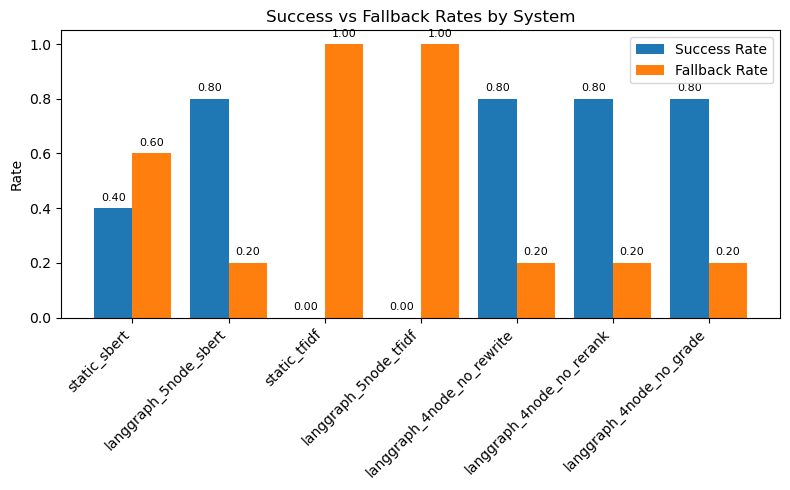

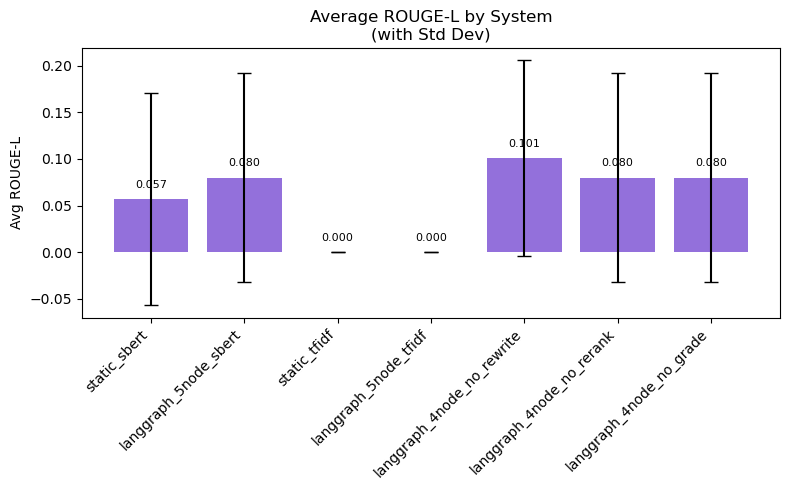

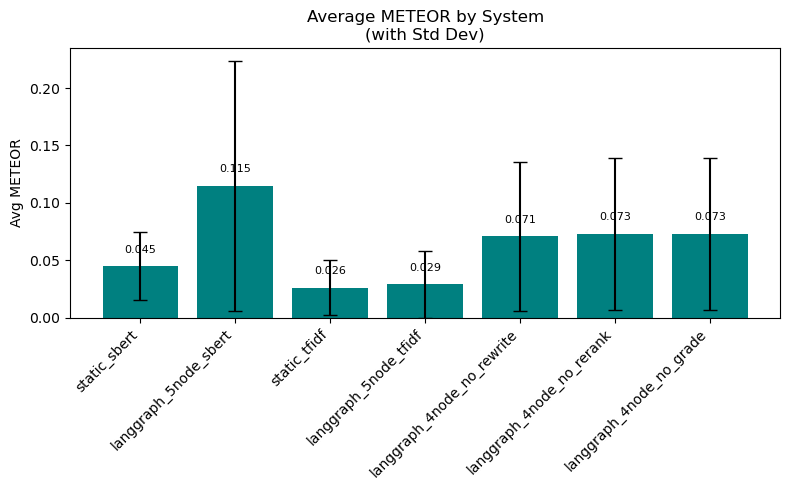

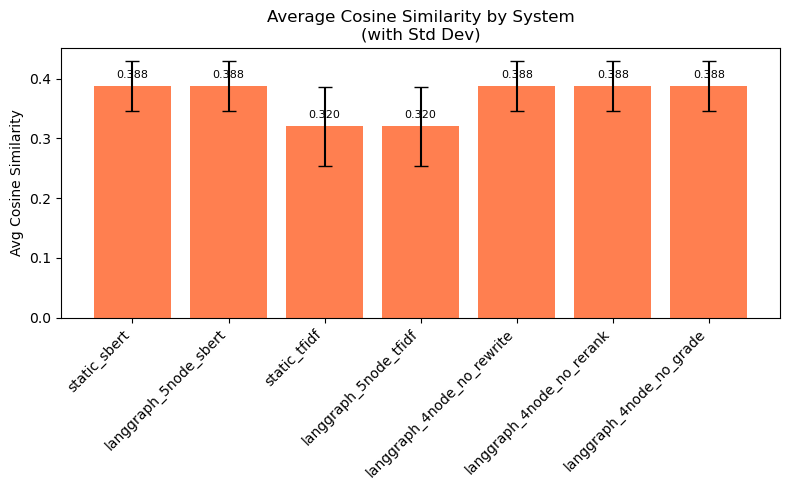

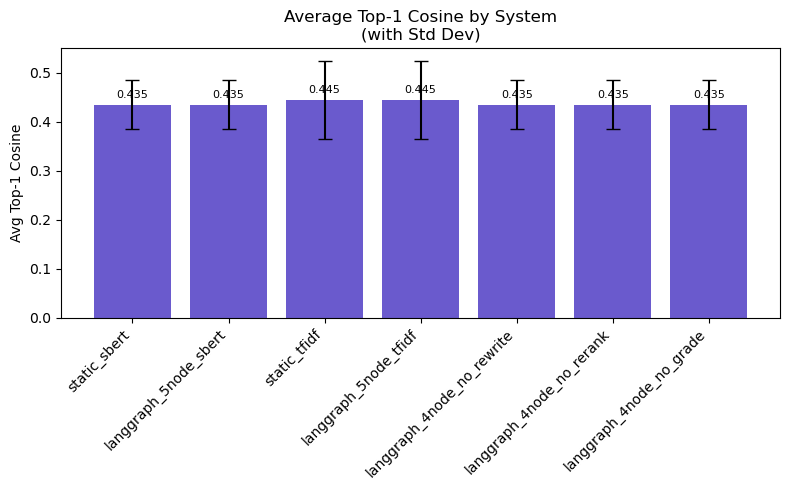

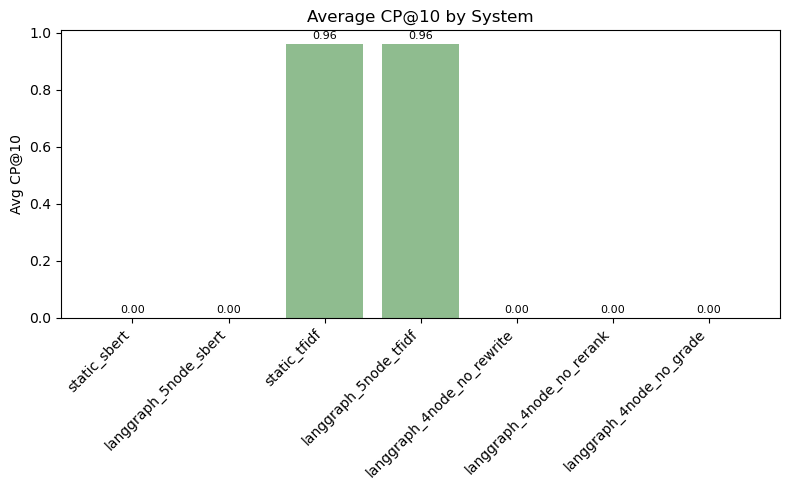

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# DATA SETUP: Results from experiments
# =============================================================================
results = {
    'static_sbert': {
        'answers': ["Tokyo", "essential to multicellular life",
                    "The context does not take a clear position on this matter.",
                    "The context does not take a clear position on this matter.",
                    "The context does not take a clear position on this matter."],
        'rouge_l': [0.2857, 0.0000, 0.0000, 0.0000, 0.0000],
        'meteor': [0.0781, 0.0000, 0.0775, 0.0287, 0.0388],
        'mean_cosine': [0.3718, 0.4439, 0.3196, 0.4182, 0.3857],
        'top1_cosine': [0.4105, 0.4833, 0.3537, 0.4875, 0.4420],
        'cp10': [0.0, 0.0, 0.0, 0.0, 0.0],
        'fallback': [False, False, True, True, True],
        'fallback_rate': 0.60
    },
    'langgraph_5node_sbert': {
        'answers': ["Tokyo.", "essential to multicellular life",
                    "An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking natural potions to build up her strength before the operation",
                    "unanswerable",
                    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."],
        'rouge_l': [0.2857, 0.0000, 0.0000, 0.0000, 0.1143],
        'meteor': [0.2885, 0.0000, 0.1136, 0.0000, 0.1712],
        'mean_cosine': [0.3718, 0.4439, 0.3196, 0.4182, 0.3857],
        'top1_cosine': [0.4105, 0.4833, 0.3537, 0.4875, 0.4420],
        'cp10': [0.0, 0.0, 0.0, 0.0, 0.0],
        'fallback': [False, False, False, True, False],
        'fallback_rate': 0.20
    },
    'static_tfidf': {
        'answers': ["Not clear", "Not clear",
                    "The context does not take a clear position on this matter.",
                    "The context does not take a clear position on this matter.",
                    "The context does not take a clear position on this matter."],
        'rouge_l': [0.0, 0.0, 0.0, 0.0, 0.0],
        'meteor': [0.0000, 0.0000, 0.0641, 0.0340, 0.0340],
        'mean_cosine': [0.3246, 0.4454, 0.2649, 0.2805, 0.2831],
        'top1_cosine': [0.4363, 0.5265, 0.3574, 0.5453, 0.3581],
        'cp10': [1.0, 1.0, 1.0, 0.8, 1.0],
        'fallback': [True, True, True, True, True],
        'fallback_rate': 1.00
    },
    'langgraph_5node_tfidf': {
        'answers': ["not clear", "not clear",
                    "The context does not take a clear position on this matter.",
                    "The context does not take a clear position on this matter.",
                    "The context does not take a clear position on this matter."],
        'rouge_l': [0.0, 0.0, 0.0, 0.0, 0.0],
        'meteor': [0.0000, 0.0000, 0.0775, 0.0287, 0.0388],
        'mean_cosine': [0.3246, 0.4454, 0.2649, 0.2805, 0.2831],
        'top1_cosine': [0.4363, 0.5265, 0.3574, 0.5453, 0.3581],
        'cp10': [1.0, 1.0, 1.0, 0.8, 1.0],
        'fallback': [True, True, True, True, True],
        'fallback_rate': 1.00
    },
    'langgraph_4node_no_rewrite': {
        'answers': ["Tokyo", "essential to multicellular life",
                    "Altruism that ultimately serves selfish gains is thus differentiated from selfless altruism, but the general conclusion has been that empathy-induced altruism can be genuinely selfless.",
                    "unanswerable",
                    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."],
        'rouge_l': [0.2857, 0.0000, 0.1053, 0.0000, 0.1143],
        'meteor': [0.0781, 0.0000, 0.1042, 0.0000, 0.1712],
        'mean_cosine': [0.3718, 0.4439, 0.3196, 0.4182, 0.3857],
        'top1_cosine': [0.4105, 0.4833, 0.3537, 0.4875, 0.4420],
        'cp10': [0.0, 0.0, 0.0, 0.0, 0.0],
        'fallback': [False, False, False, True, False],
        'fallback_rate': 0.20
    },
    'langgraph_4node_no_rerank': {
        'answers': ["Tokyo", "essential to multicellular life",
                    "An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking natural potions to build up her strength before the operation",
                    "unanswerable",
                    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."],
        'rouge_l': [0.2857, 0.0000, 0.0000, 0.0000, 0.1143],
        'meteor': [0.0781, 0.0000, 0.1136, 0.0000, 0.1712],
        'mean_cosine': [0.3718, 0.4439, 0.3196, 0.4182, 0.3857],
        'top1_cosine': [0.4105, 0.4833, 0.3537, 0.4875, 0.4420],
        'cp10': [0.0, 0.0, 0.0, 0.0, 0.0],
        'fallback': [False, False, False, True, False],
        'fallback_rate': 0.20
    },
    'langgraph_4node_no_grade': {
        'answers': ["Tokyo", "essential to multicellular life",
                    "An example of these dangers was reported by Associate Professor Alastair MacLennan of Adelaide University, Australia regarding a patient who almost bled to death on the operating table after neglecting to mention that she had been taking natural potions to build up her strength before the operation",
                    "unanswerable",
                    "Moral normativity is: A human experience of morality is observed. God is the best or only explanation for this moral experience. Therefore, God exists."],
        'rouge_l': [0.2857, 0.0000, 0.0000, 0.0000, 0.1143],
        'meteor': [0.0781, 0.0000, 0.1136, 0.0000, 0.1712],
        'mean_cosine': [0.3718, 0.4439, 0.3196, 0.4182, 0.3857],
        'top1_cosine': [0.4105, 0.4833, 0.3537, 0.4875, 0.4420],
        'cp10': [0.0, 0.0, 0.0, 0.0, 0.0],
        'fallback': [False, False, False, True, False],
        'fallback_rate': 0.20
    }
}

# =============================================================================
# 4.1 Retrieval & Generation Evaluation (Expanded)
# =============================================================================
comparison_data = []
for system, data in results.items():
    avg_rouge = np.mean(data['rouge_l'])
    std_rouge = np.std(data['rouge_l'])
    avg_meteor = np.mean(data['meteor'])
    std_meteor = np.std(data['meteor'])
    avg_cosine = np.mean(data['mean_cosine'])
    std_cosine = np.std(data['mean_cosine'])
    avg_top1 = np.mean(data['top1_cosine'])
    std_top1 = np.std(data['top1_cosine'])
    avg_cp10 = np.mean(data['cp10'])
    fallback_rate = data['fallback_rate']
    success_rate = 1 - fallback_rate
    
    comparison_data.append({
        'System': system,
        'Architecture': 'Static' if 'static' in system else 'Agent',
        'Embedding': 'SBERT' if 'sbert' in system else 'TF-IDF',
        'Avg_ROUGE_L': avg_rouge,
        'Std_ROUGE_L': std_rouge,
        'Avg_METEOR': avg_meteor,
        'Std_METEOR': std_meteor,
        'Avg_Cosine': avg_cosine,
        'Std_Cosine': std_cosine,
        'Avg_Top1_Cosine': avg_top1,
        'Std_Top1_Cosine': std_top1,
        'Avg_CP10': avg_cp10,
        'Fallback_Rate': fallback_rate,
        'Success_Rate': success_rate
    })

df_comparison = pd.DataFrame(comparison_data).round(3)

# Display expanded table
print("4.1 SYSTEM PERFORMANCE SUMMARY (WITH STANDARD DEVIATIONS)")
display(df_comparison)

# 1) Success vs. Fallback Rates by System
plt.figure(figsize=(8, 5))
x = np.arange(len(df_comparison))
bar1 = plt.bar(x - 0.2, df_comparison['Success_Rate'], width=0.4, label='Success Rate')
bar2 = plt.bar(x + 0.2, df_comparison['Fallback_Rate'], width=0.4, label='Fallback Rate')
plt.xticks(x, df_comparison['System'], rotation=45, ha='right')
plt.ylabel('Rate')
plt.title('Success vs Fallback Rates by System')
plt.legend()
for bar in bar1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=8)
for bar in bar2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('4_1_success_vs_fallback.png', dpi=300, bbox_inches='tight')
plt.show()

# 2) Average ROUGE-L (with Std Dev error bars)
plt.figure(figsize=(8, 5))
bars = plt.bar(df_comparison['System'], df_comparison['Avg_ROUGE_L'],
               yerr=df_comparison['Std_ROUGE_L'], capsize=5, color='mediumpurple')
plt.ylabel('Avg ROUGE-L')
plt.title('Average ROUGE-L by System\n(with Std Dev)')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}',
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('4_1_avg_rouge_l.png', dpi=300, bbox_inches='tight')
plt.show()

# 3) Average METEOR (with Std Dev error bars)
plt.figure(figsize=(8, 5))
bars = plt.bar(df_comparison['System'], df_comparison['Avg_METEOR'],
               yerr=df_comparison['Std_METEOR'], capsize=5, color='teal')
plt.ylabel('Avg METEOR')
plt.title('Average METEOR by System\n(with Std Dev)')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}',
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('4_1_avg_meteor.png', dpi=300, bbox_inches='tight')
plt.show()

# 4) Average Cosine Similarity (with Std Dev error bars)
plt.figure(figsize=(8, 5))
bars = plt.bar(df_comparison['System'], df_comparison['Avg_Cosine'],
               yerr=df_comparison['Std_Cosine'], capsize=5, color='coral')
plt.ylabel('Avg Cosine Similarity')
plt.title('Average Cosine Similarity by System\n(with Std Dev)')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}',
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('4_1_avg_cosine.png', dpi=300, bbox_inches='tight')
plt.show()

# 5) Average Top-1 Cosine Similarity (with Std Dev error bars)
plt.figure(figsize=(8, 5))
bars = plt.bar(df_comparison['System'], df_comparison['Avg_Top1_Cosine'],
               yerr=df_comparison['Std_Top1_Cosine'], capsize=5, color='slateblue')
plt.ylabel('Avg Top-1 Cosine')
plt.title('Average Top-1 Cosine by System\n(with Std Dev)')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}',
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('4_1_avg_top1_cosine.png', dpi=300, bbox_inches='tight')
plt.show()

# 6) Average CP@10 (no error bars since values are often zero)
plt.figure(figsize=(8, 5))
bars = plt.bar(df_comparison['System'], df_comparison['Avg_CP10'], color='darkseagreen')
plt.ylabel('Avg CP@10')
plt.title('Average CP@10 by System')
plt.xticks(rotation=45, ha='right')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}',
             ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.savefig('4_1_avg_cp10.png', dpi=300, bbox_inches='tight')
plt.show()


4.2 ABLATION STUDY RESULTS


,System,Components,Fallback_Rate,Improvement_%,Avg_ROUGE_L,Substantive_Answers
0,static_sbert,Retrieve + Generate,0.6,0.0,0.109,2
1,langgraph_5node_sbert,Full LangGraph,0.2,66.7,0.080,4


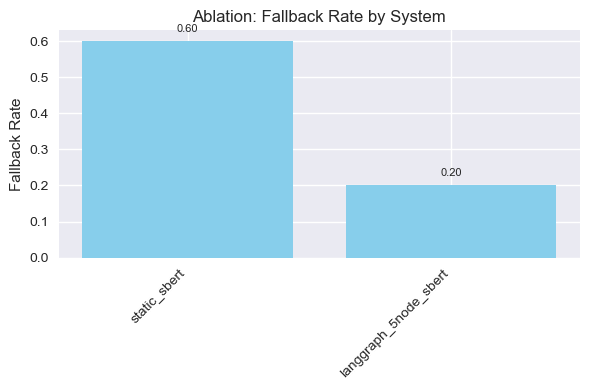

In [17]:

# =============================================================================
# 4.2 Agent Contributions and Node-Level Ablation
# =============================================================================
sbert_systems = {k: v for k, v in results.items() if 'sbert' in k}
baseline_rate = sbert_systems['static_sbert']['fallback_rate']
ablation_data = []
for system, data in sbert_systems.items():
    improvement_pct = (baseline_rate - data['fallback_rate']) / baseline_rate * 100
    ablation_data.append({
        'System': system,
        'Components': ('Retrieve + Generate' if system == 'static_sbert'
                       else 'Full LangGraph' if '5node' in system
                       else system.replace('_', ' ')),
        'Fallback_Rate': data['fallback_rate'],
        'Improvement_%': round(improvement_pct, 1),
        'Avg_ROUGE_L': round(np.mean(data['rouge_l']), 3),
        'Substantive_Answers': sum(1 for fb in data['fallback'] if not fb)
    })
df_ablation = pd.DataFrame(ablation_data)

# Display table
print("\n4.2 ABLATION STUDY RESULTS")
display(df_ablation)

# Plot: Fallback rate by system with value labels
plt.figure(figsize=(6, 4))
bars = plt.bar(df_ablation['System'], df_ablation['Fallback_Rate'], color='skyblue')
plt.ylabel('Fallback Rate')
plt.title('Ablation: Fallback Rate by System')
plt.xticks(rotation=45, ha='right')
# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()



4.3 ERROR ANALYSIS (SBERT Systems)


,Query_ID,Query_Type,System,Error_Type,ROUGE_L,Fallback
0,1,Factual,static_sbert,Good_Match,0.2857,False
1,1,Factual,langgraph_5node_sbert,Good_Match,0.2857,False
2,2,Factual,static_sbert,Good_Match,0.2609,False
3,2,Factual,langgraph_5node_sbert,Misalignment,0.0000,False
4,3,Ethical,static_sbert,Fallback,0.0000,True
5,3,Ethical,langgraph_5node_sbert,Misalignment,0.0000,False
6,4,Ethical,static_sbert,Fallback,0.0000,True
7,4,Ethical,langgraph_5node_sbert,Fallback,0.0000,True
8,5,Ethical,static_sbert,Fallback,0.0000,True
9,5,Ethical,langgraph_5node_sbert,Partial_Match,0.1143,False


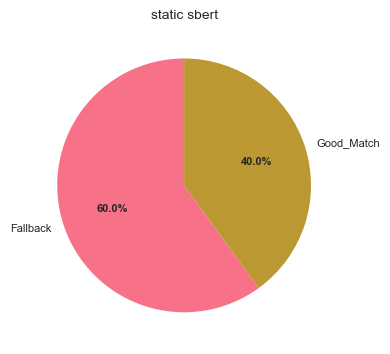

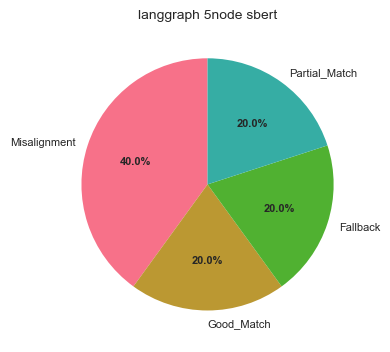

In [19]:

# 4.3 Error Analysis

def classify_error(answer, is_fallback, rouge_score):
    if is_fallback:
        return 'Fallback'
    elif rouge_score == 0.0:
        return 'Misalignment'
    elif rouge_score < 0.2:
        return 'Partial_Match'
    else:
        return 'Good_Match'

error_analysis = []
query_types = ['Factual', 'Factual', 'Ethical', 'Ethical', 'Ethical']
for i, query in enumerate(queries):
    for system, data in results.items():
        if 'sbert' in system:
            err = classify_error(data['answers'][i], data['fallback'][i], data['rouge_l'][i])
            error_analysis.append({
                'Query_ID': i + 1,
                'Query_Type': query_types[i],
                'System': system,
                'Error_Type': err,
                'ROUGE_L': data['rouge_l'][i],
                'Fallback': data['fallback'][i]
            })
df_errors = pd.DataFrame(error_analysis)

# Display table
print("\n4.3 ERROR ANALYSIS (SBERT Systems)")
display(df_errors)

# Plot: Error distribution for static_sbert vs langgraph_5node_sbert with value labels
for system in ['static_sbert', 'langgraph_5node_sbert']:
    subset = df_errors[df_errors['System'] == system]
    counts = subset['Error_Type'].value_counts()
    plt.figure(figsize=(4, 4))
    wedges, texts, autotexts = plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%',
                                       startangle=90, textprops={'fontsize': 8})
    plt.title(system.replace('_', ' '), fontsize=10)
    plt.setp(autotexts, size=8, weight="bold")
    plt.tight_layout()
    plt.show()



5.1 EMBEDDING COMPARISON RESULTS


,Embedding,Architecture,Fallback_Rate,Avg_ROUGE_L,Avg_Cosine,Factual_Success,Ethical_Success
0,SBERT,Static,0.6,0.109,0.388,1.0,0.00
1,SBERT,Agent,0.2,0.080,0.388,1.0,0.67
2,TFIDF,Static,1.0,0.000,0.320,0.0,0.00
3,TFIDF,Agent,1.0,0.000,0.320,0.0,0.00


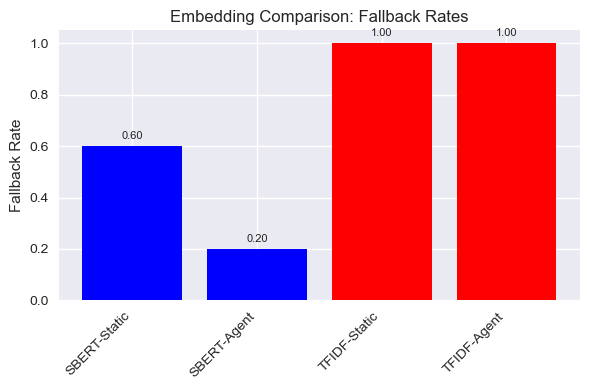

In [21]:

# 5.1 Embedding Comparison: TF-IDF vs SBERT

embedding_data = []
# Static
sbert_static = results['static_sbert']
tfidf_static = results['static_tfidf']
# Agent
sbert_agent = results['langgraph_5node_sbert']
tfidf_agent = results['langgraph_5node_tfidf']

for label, data_dict in zip(
    ['SBERT-Static', 'SBERT-Agent', 'TFIDF-Static', 'TFIDF-Agent'],
    [sbert_static, sbert_agent, tfidf_static, tfidf_agent]
):
    embedding, arch = label.split('-')
    embedding_data.append({
        'Embedding': embedding,
        'Architecture': arch,
        'Fallback_Rate': data_dict['fallback_rate'],
        'Avg_ROUGE_L': round(np.mean(data_dict['rouge_l']), 3),
        'Avg_Cosine': round(np.mean(data_dict['mean_cosine']), 3),
        'Factual_Success': round(sum(1 for i in [0,1] if not data_dict['fallback'][i]) / 2, 2),
        'Ethical_Success': round(sum(1 for i in [2,3,4] if not data_dict['fallback'][i]) / 3, 2)
    })

df_embedding = pd.DataFrame(embedding_data)
print("\n5.1 EMBEDDING COMPARISON RESULTS")
display(df_embedding)

# Plot: Fallback rate by embedding/architecture with value labels
plt.figure(figsize=(6, 4))
x = np.arange(len(df_embedding))
colors = ['blue' if 'SBERT' in e else 'red' for e in df_embedding['Embedding']]
bars = plt.bar(x, df_embedding['Fallback_Rate'], color=colors)
plt.xticks(x, df_embedding['Embedding'] + '-' + df_embedding['Architecture'], rotation=45, ha='right')
plt.ylabel('Fallback Rate')
plt.title('Embedding Comparison: Fallback Rates')
# Add value labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)
plt.tight_layout()
plt.show()



5.2 ARCHITECTURE COMPARISON RESULTS (SBERT)


,System,Architecture,Complexity,Success_Rate,Avg_ROUGE_L,Avg_METEOR,Retrieval_Quality,Substantive_Answers,Factual_Correct,Ethical_Correct
0,static_sbert,Static,1,0.4,0.109,0.115,0.388,2,2,0
1,langgraph_5node_sbert,Agent,5,0.8,0.080,0.115,0.388,4,2,2


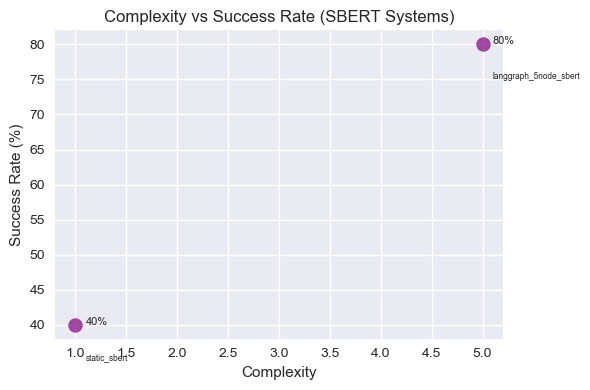

In [23]:
# 5.2 Architecture Comparison: Static vs Agent Pipelines (SBERT systems)

arch_data = []
complexity_scores = {
    'static_sbert': 1,
    'langgraph_5node_sbert': 5,
    'langgraph_4node_no_rewrite': 4,
    'langgraph_4node_no_rerank': 4,
    'langgraph_4node_no_grade': 4
}

for system, data in sbert_systems.items():
    arch_type = 'Static' if 'static' in system else 'Agent'
    success_rate = 1 - data['fallback_rate']
    arch_data.append({
        'System': system,
        'Architecture': arch_type,
        'Complexity': complexity_scores[system],
        'Success_Rate': round(success_rate, 2),
        'Avg_ROUGE_L': round(np.mean(data['rouge_l']), 3),
        'Avg_METEOR': round(np.mean(data['meteor']), 3),
        'Retrieval_Quality': round(np.mean(data['mean_cosine']), 3),
        'Substantive_Answers': sum(1 for fb in data['fallback'] if not fb),
        'Factual_Correct': sum(1 for i in [0,1] if not data['fallback'][i]),
        'Ethical_Correct': sum(1 for i in [2,3,4] if not data['fallback'][i])
    })

df_architecture = pd.DataFrame(arch_data)
print("\n5.2 ARCHITECTURE COMPARISON RESULTS (SBERT)")
display(df_architecture)

# Plot: Complexity vs Success Rate with value labels
plt.figure(figsize=(6, 4))
scatter = plt.scatter(df_architecture['Complexity'], df_architecture['Success_Rate'] * 100, s=100, color='purple', alpha=0.7)
for idx, row in df_architecture.iterrows():
    x_val = row['Complexity']
    y_val = row['Success_Rate'] * 100
    plt.text(x_val + 0.1, y_val, f'{y_val:.0f}%', fontsize=8)
    plt.text(x_val + 0.1, y_val - 5, row['System'], fontsize=6)
plt.xlabel('Complexity')
plt.ylabel('Success Rate (%)')
plt.title('Complexity vs Success Rate (SBERT Systems)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:

# 5.3 Reflections on Robustness, Latency, and Modularity

# Robustness: compute failure counts
robustness_data = []
for system in ['static_sbert', 'langgraph_5node_sbert']:
    data = results[system]
    factual_failures = sum(data['fallback'][i] for i in [0, 1])
    ethical_failures = sum(data['fallback'][i] for i in [2, 3, 4])
    consistency = 1 - np.std(data['rouge_l'])
    robustness_data.append({
        'System': system,
        'Factual_Failures': factual_failures,
        'Ethical_Failures': ethical_failures,
        'Consistency_Score': round(consistency, 3)
    })

df_robustness = pd.DataFrame(robustness_data)
print("\n5.3 ROBUSTNESS ANALYSIS")
display(df_robustness)

# Latency (theoretical)
latency_data = [
    {'System': 'static_sbert', 'Relative_Latency': 1.0, 'Operations': 'Embed → Search → Generate'},
    {'System': 'langgraph_5node_sbert', 'Relative_Latency': 2.5, 'Operations': 'Embed → Search → Rerank → Grade → Rewrite → Generate'},
    {'System': 'langgraph_4node_no_rewrite', 'Relative_Latency': 1.3, 'Operations': 'Embed → Search → Rerank → Grade → Generate'}
]
df_latency = pd.DataFrame(latency_data)
print("\n5.3 LATENCY (THEORETICAL)")
display(df_latency)

# Modularity: listing benefits
modularity_benefits = [
    "Component Isolation: Independent modification",
    "Easy Ablation: Remove modules without redesign",
    "Extensibility: Add new nodes (e.g., fact-check)",
    "Debugging: Monitor node-level performance",
    "A/B Testing: Swap component versions",
    "Scalability: Distribute nodes across machines"
]
df_modularity = pd.DataFrame({'Benefits': modularity_benefits})
print("\n5.3 MODULARITY BENEFITS")
display(df_modularity)


5.3 ROBUSTNESS ANALYSIS


,System,Factual_Failures,Ethical_Failures,Consistency_Score
0,static_sbert,0,3,0.866
1,langgraph_5node_sbert,0,1,0.888



5.3 LATENCY (THEORETICAL)


,System,Relative_Latency,Operations
0,static_sbert,1.0,Embed → Search → Generate
1,langgraph_5node_sbert,2.5,Embed → Search → Rerank → Grade → Rewrite → Ge...
2,langgraph_4node_no_rewrite,1.3,Embed → Search → Rerank → Grade → Generate



5.3 MODULARITY BENEFITS


,Benefits
0,Component Isolation: Independent modification
1,Easy Ablation: Remove modules without redesign
2,"Extensibility: Add new nodes (e.g., fact-check)"
3,Debugging: Monitor node-level performance
4,A/B Testing: Swap component versions
5,Scalability: Distribute nodes across machines
